In [32]:
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt
from glob import glob
import cv2, os

# File Paths 

In [33]:
train_path = glob('training/*/*.jpg')
test_path = glob('validation/*/*.jpg')
evaluation_path = glob('evaluation/*/*.jpg')

In [34]:
folders = glob('training/*')
folders

['training/non_food', 'training/food']

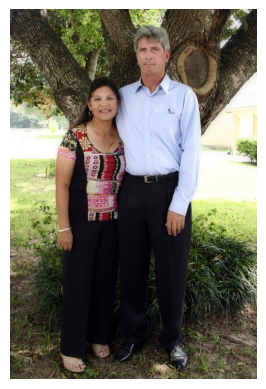

In [35]:
## Import a random image for testing 

plt.imshow(tf.keras.preprocessing.image.load_img(np.random.choice(train_path)))
plt.axis('Off')
plt.show;

# Using the keras library to call a pre-trained model called the VGG-16

In [37]:
IMAGE_SHAPE = [200, 200]
ptm = tf.keras.applications.vgg16.VGG16(
    input_shape=IMAGE_SHAPE + [3],
    weights='imagenet',
    include_top=False,   
)

In [38]:
## we dont want to re-train the pre-trained vgg16 model so we use the following code 

ptm.trainable = False

In [39]:
x = tf.keras.layers.Flatten()(ptm.output)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=ptm.input, outputs=x)

In [40]:
## Looking at all the layers of the model in brief
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

# Data Augmentation

In [41]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=True,
    rotation_range=.1,
    shear_range=.2,
    zoom_range=.2
)

In [42]:
## Train data gen

train_gen = gen.flow_from_directory(
    'training',
    target_size=IMAGE_SHAPE,
    batch_size=128,
    shuffle=True,
)

# Test data gen

test_gen = gen.flow_from_directory(
    'validation',
    target_size=IMAGE_SHAPE,
    batch_size=128
)

len(train_gen), len(test_gen)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(24, 8)

# Running the model on the datasets..

In [18]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=len(train_gen), validation_steps=len(test_gen), epochs=10)

Epoch 1/10


2024-02-04 15:56:05.587504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 4.7916 - accuracy: 0.8403

2024-02-04 15:56:48.076564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 56s 2s/step - loss: 4.7916 - accuracy: 0.8403 - val_loss: 1.9874 - val_accuracy: 0.9270
Epoch 2/10
24/24 [==============================] - 55s 2s/step - loss: 1.4910 - accuracy: 0.9377 - val_loss: 1.6970 - val_accuracy: 0.9340
Epoch 3/10
24/24 [==============================] - 64s 3s/step - loss: 1.1654 - accuracy: 0.9517 - val_loss: 1.6516 - val_accuracy: 0.9420
Epoch 4/10
24/24 [==============================] - 70s 3s/step - loss: 0.9517 - accuracy: 0.9557 - val_loss: 1.4515 - val_accuracy: 0.9330
Epoch 5/10
24/24 [==============================] - 71s 3s/step - loss: 0.6634 - accuracy: 0.9617 - val_loss: 1.3663 - val_accuracy: 0.9320
Epoch 6/10
24/24 [==============================] - 72s 3s/step - loss: 0.7478 - accuracy: 0.9593 - val_loss: 1.3175 - val_accuracy: 0.9370
Epoch 7/10
24/24 [==============================] - 73s 3s/step - loss: 0.5378 - accuracy: 0.9667 - val_loss: 1.4553 - val_accuracy: 0.9400
Epoch 8/10
24/24 [=============

In [77]:
def plotting_graph(v1, v2):
    plt.plot(r.history[v1], label=v1)
    plt.plot(r.history[v2], label=v2)
    plt.grid()
    plt.title(f'{v1} per epoch')
    plt.xlabel('epochs')
    plt.ylabel(v1)
    plt.show();

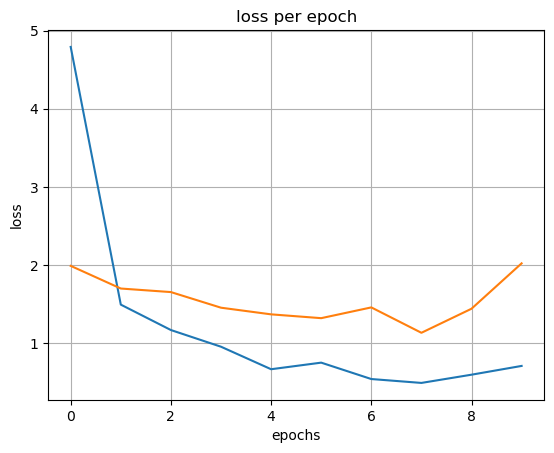

In [78]:
plotting_graph('loss', 'val_loss')

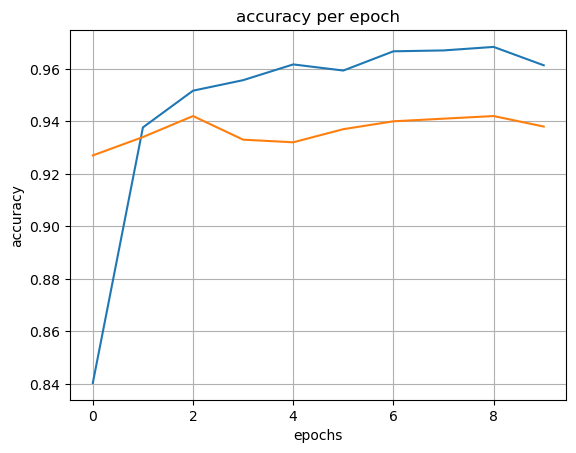

In [79]:
plotting_graph('accuracy', 'val_accuracy')

# Model Prediction using CV2 

In [69]:
classes = ['Food', 'Non-Food']

In [80]:
def make_predictions(test_idx, true_class):
    num_images_to_predict = min(1, len(test_idx))

    for i in range(num_images_to_predict):
        image_path = str(test_idx[i])
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (200, 200))
            image = np.expand_dims(image, axis=0)
            pred = model.predict(image)
            pred_class = classes[np.argmax(pred)]
            plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))  # Extracting the first image from the batch
            plt.title(f'True class: {true_class}, Predicted class: {pred_class}')
            plt.axis('off')
            plt.show()

1/1 [==============================] - 0s 16ms/step


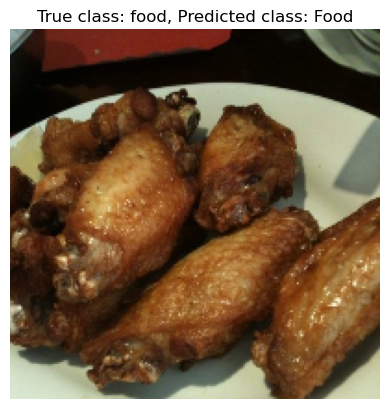

1/1 [==============================] - 0s 14ms/step


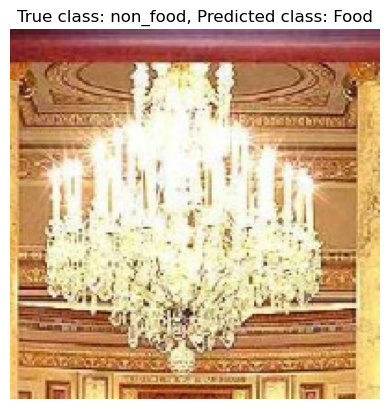

1/1 [==============================] - 0s 13ms/step


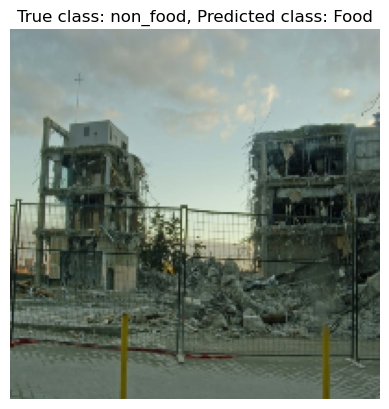

1/1 [==============================] - 0s 23ms/step


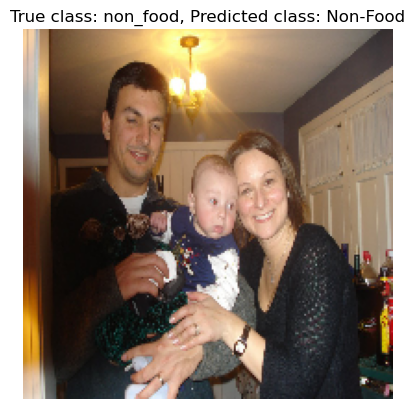

1/1 [==============================] - 0s 13ms/step


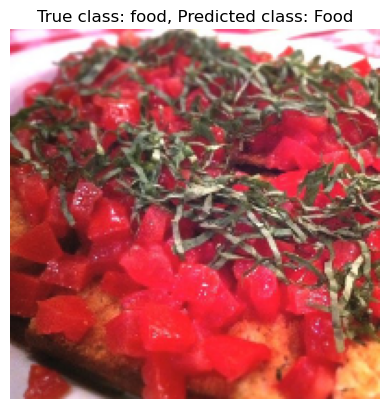

In [81]:
for i in range(5):
    pred_idx = np.random.choice(evaluation_path)
    make_predictions(test_idx=[pred_idx], true_class=pred_idx.split('/')[1])

# The model is doing good even tho it, sometimes gets the classes wrong. We can consider this to be good model to classify between food and non-food.